In [ ]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

class SpectrogramDataset(Dataset):
    """
    Custom dataset for loading spectrogram images and extracting class labels from filenames.
    Labels:
        - 0: Healthy Control (HC)
        - 1: Parkinson's Disease (PD)
        - 2: Parkinsonism (MSA, PSP)
    """

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory containing spectrogram images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.filenames = [f for f in os.listdir(root_dir) if f.endswith(".png") or f.endswith(".jpg")]
        self.transform = transform
        self.samples = []

        for fname in self.filenames:
            parsed = self.parse_filename(fname)
            if parsed:
                speaker_id, label = parsed
                self.samples.append((fname, label))

    def parse_filename(self, filename):
        """
        Parses filename to extract speaker group and assigns label accordingly.
        Expected format: [GROUP][ID][vowel][rep] e.g., PD12a1
        Returns:
            (str, int): speaker_id, label
        """
        match = re.match(r"([A-Z]+)(\d+)([ai])(\d+)", filename)
        if not match:
            return None
        group, subject_id, vowel, rep = match.groups()

        if group == "HC":
            label = 0
        elif group == "PD":
            label = 1
        elif group in ["MSA", "PSP"]:
            label = 2
        else:
            return None

        speaker_id = f"{group}{subject_id}"
        return speaker_id, label

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Loads and returns an image and its label.
        Returns:
            (Tensor, int): transformed image, label
        """
        fname, label = self.samples[idx]
        path = os.path.join(self.root_dir, fname)
        image = Image.open(path).convert("L")  # convert to grayscale

        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Image preprocessing
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

# Initialise dataset and create train/test splits (80/20)
dataset = SpectrogramDataset("melspectrograms", transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16)


class TransformerEncoderLayerWithAttn(nn.TransformerEncoderLayer):
    """
    Subclass of TransformerEncoderLayer that stores attention weights during forward pass.
    Useful for visualizing and interpreting attention patterns.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.attn_weights = None

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Apply self-attention and store attention weights
        src2, attn = self.self_attn(
            src, src, src, attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=True,
            average_attn_weights=False
        )
        self.attn_weights = attn.detach()
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src


In [ ]:
class PatchEmbed(nn.Module):
    """
    Converts an image into a sequence of patch embeddings.
    """
    def __init__(self, img_size=(128, 128), patch_size=16, in_chans=1, embed_dim=128):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size, img_size[1] // patch_size)
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        # Patch projection via strided convolution
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)                      # (B, C, H/patch, W/patch)
        x = x.flatten(2).transpose(1, 2)      # (B, num_patches, embed_dim)
        return x


class ViTClassifier(nn.Module):
    """
    Vision Transformer (ViT) for classifying spectrograms into 3 classes.
    Includes attention recording for interpretability.
    """
    def __init__(self, img_size=(128, 128), patch_size=16, in_chans=1, embed_dim=128, num_heads=4, depth=4, num_classes=3):
        super().__init__()

        # Patch embedding module
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        # Classification token and positional encoding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))

        # Transformer layers with attention tracking
        self.layers = nn.ModuleList([
            TransformerEncoderLayerWithAttn(d_model=embed_dim, nhead=num_heads, batch_first=True)
            for _ in range(depth)
        ])

        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x) # (B, N, D)
        cls_tokens = self.cls_token.expand(B, -1, -1) # (B, 1, D)
        x = torch.cat((cls_tokens, x), dim=1) # prepend [CLS] token
        x = x + self.pos_embed # add positional encoding

        self.attn_weights = []

        for layer in self.layers:
            x = layer(x)
            self.attn_weights.append(layer.attn_weights) # collect attention maps

        return self.head(x[:, 0]) # classify using [CLS] token


In [ ]:
def train_model(model, train_loader, test_loader, epochs=10, lr=1e-4):
    """
    Trains the model using cross-entropy loss and Adam optimizer.
    Prints epoch-wise loss and accuracy.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * y.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        acc = correct / total
        print(f"Epoch {epoch+1}: Loss = {total_loss / total:.4f}, Accuracy = {acc:.4f}")

    return model


In [ ]:
def evaluate(model, test_loader):
    """
    Evaluates the model on test set and plots the confusion matrix.
    Prints classification report.
    """
    device = torch.device("cpu")
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            out = model(X)
            preds = out.argmax(dim=1).cpu().numpy()
            y_true.extend(y.numpy())
            y_pred.extend(preds)

    # Compute and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=["HC", "PD", "Parkinsonism"])

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["HC", "PD", "Parkinsonism"], yticklabels=["HC", "PD", "Parkinsonism"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print(report)



Epoch 1: Loss = 1.0561, Accuracy = 0.4655
Epoch 2: Loss = 0.9730, Accuracy = 0.5345
Epoch 3: Loss = 0.9668, Accuracy = 0.5345
Epoch 4: Loss = 1.0017, Accuracy = 0.4526
Epoch 5: Loss = 0.9731, Accuracy = 0.5431
Epoch 6: Loss = 0.9421, Accuracy = 0.5560
Epoch 7: Loss = 0.9555, Accuracy = 0.5603
Epoch 8: Loss = 0.9487, Accuracy = 0.5302
Epoch 9: Loss = 0.9444, Accuracy = 0.5647
Epoch 10: Loss = 0.9438, Accuracy = 0.5517
Epoch 11: Loss = 0.9630, Accuracy = 0.5000
Epoch 12: Loss = 0.9642, Accuracy = 0.5474
Epoch 13: Loss = 0.9315, Accuracy = 0.5259
Epoch 14: Loss = 0.9332, Accuracy = 0.5216
Epoch 15: Loss = 0.9462, Accuracy = 0.5388
Epoch 16: Loss = 0.9479, Accuracy = 0.5086
Epoch 17: Loss = 0.9285, Accuracy = 0.5302
Epoch 18: Loss = 0.9117, Accuracy = 0.5819
Epoch 19: Loss = 0.9029, Accuracy = 0.5431
Epoch 20: Loss = 0.8770, Accuracy = 0.5603
Epoch 21: Loss = 0.8348, Accuracy = 0.5991
Epoch 22: Loss = 0.8472, Accuracy = 0.5690
Epoch 23: Loss = 0.8643, Accuracy = 0.5733
Epoch 24: Loss = 0.7

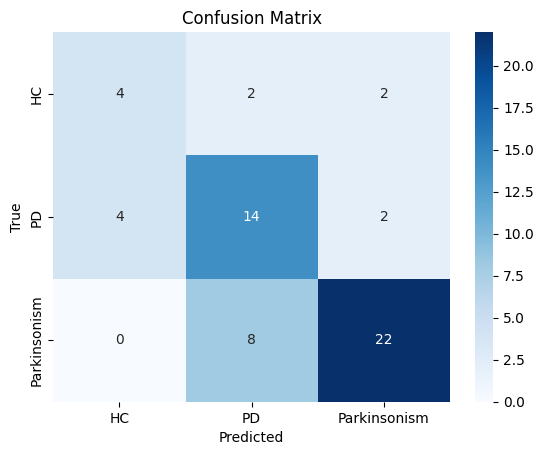

              precision    recall  f1-score   support

          HC       0.50      0.50      0.50         8
          PD       0.58      0.70      0.64        20
Parkinsonism       0.85      0.73      0.79        30

    accuracy                           0.69        58
   macro avg       0.64      0.64      0.64        58
weighted avg       0.71      0.69      0.69        58



In [ ]:
# Initialise model and run training + evaluation
model = ViTClassifier(img_size=(128, 128), num_classes=3)
model = train_model(model, train_loader, test_loader, epochs=50)
evaluate(model, test_loader)